In [1]:
import json
import os
import sys
import datetime
from pathlib import Path
from IPython.display import Markdown, display

from pydantic import BaseModel, Field, model_validator
from pydantic_ai import Agent

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
from gepadantic import SignatureAgent, GepaConfig, run_optimization_pipeline, get_openai_model, split_dataset
from gepadantic.schema import DataInstWithInput, RolloutOutput, InputModelT

In [4]:
with open('../data/dummy_medical_records.json', 'r') as f:
    medical_records = json.load(f)

In [5]:
class MedicalRecord(BaseModel):
    """A single medical record with associated metadata."""
    
    medical_record: str = Field(description="Full text of the medical record")
    date_of_service: datetime.date = Field(description="Date of service")
    user_feedback: str | None = Field(default=None, description="User feedback on the record")
    
    def __str__(self):
        out_string = ""
        out_string += f"**Date of Service**: {self.date_of_service}\n\n"
        out_string += f"**Medical Record**: {self.medical_record[:180]}...\n\n"
        out_string += f"**User Feedback**: {self.user_feedback}\n\n"
        out_string += "---\n\n"
        return out_string


class MedicalRecords(BaseModel):
    """Collection of medical records."""
    
    records: list[MedicalRecord] = Field(description="List of medical records")
    
    @classmethod
    def from_json_file(cls, file_path: str | Path) -> "MedicalRecords":
        """Load medical records from a JSON file.
        
        Args:
            file_path: Path to the JSON file containing an array of medical records
            
        Returns:
            MedicalRecords object containing the parsed records
        """
        path = Path(file_path)
        with path.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        return cls(records=data)

In [6]:
records = MedicalRecords.from_json_file('../data/dummy_medical_records.json')

len(records.records)

10

In [7]:
for record in records.records[:3]:
    display(Markdown(str(record)))

**Date of Service**: 2025-04-02

**Medical Record**: EMERGENCY MEDICAL SERVICES RUN REPORT

Patient Name: Jonathan Parker
DOB: 03/22/1987
Sex: Male
Incident Date/Time: 04/02/2025 17:38
Date of Service: 04/02/2025
Run Number: EMS-25-1...

**User Feedback**: Summary should not include full DOB, only their current age and city/state of residence. I also think bullet point would be easier to read.

---



**Date of Service**: 2025-04-02

**Medical Record**: EMERGENCY DEPARTMENT VISIT NOTE

Facility: Starlight Regional Medical Center
Address: 2100 W 5th St, Austin, TX 78703
ED Encounter #: ED-25-449302
Date of Service: 04/02/2025

Pati...

**User Feedback**: Their correct age as of 1/1/2026 is 38. Residence should be limited to city and state only, not the full address. on the records we just need a high level breakdown, no need to go into things like vital signs. 

---



**Date of Service**: 2025-04-02

**Medical Record**: DIAGNOSTIC IMAGING REPORT – CT CERVICAL SPINE

Facility: Starlight Regional Medical Center Radiology Department
Address: 2100 W 5th St, Austin, TX 78703
Exam Date / Date of Service...

**User Feedback**: If we have impressions we don't need to include findings as well. However we do need specific objective results from the imaging studies.

---



In [8]:
class MedicalRecordInput(BaseModel):
    """A single medical document with associated metadata."""
    
    text: str = Field(description="Full text of the medical document")


class MedicalRecordOutput(BaseModel):
    """A single entry in the medical chronology."""
    
    date_of_service: datetime.date = Field(description="Date of service")
    provider_name: str = Field(description="Name of the provider")
    description: str = Field(description="Description entry for a chronology")
    
    def __str__(self):
        return f"{self.date_of_service}\n\n{self.provider_name}\n\n{self.description}"


In [9]:
Markdown(records.records[0].medical_record)

EMERGENCY MEDICAL SERVICES RUN REPORT

Patient Name: Jonathan Parker
DOB: 03/22/1987
Sex: Male
Incident Date/Time: 04/02/2025 17:38
Date of Service: 04/02/2025
Run Number: EMS-25-18432

Pickup Location: I-35 Northbound at Exit 247, Austin, TX 78753
Destination Facility: Starlight Regional Medical Center, 2100 W 5th St, Austin, TX 78703

Primary Insurance: Lone Star Auto & Casualty, Claim #LSA-2025-48192
Secondary Insurance: SilverShield Health PPO, Member ID: SSH-77492038-01

CHIEF COMPLAINT:
Motor vehicle collision. Patient was restrained driver rear-ended at highway speed, complaining of neck pain, mid-back pain, and frontal headache.

HISTORY OF PRESENT ILLNESS:
38-year-old male involved in rear-end MVC at approximately 17:20. Patient reports being stopped in traffic when struck from behind by a pickup truck. No airbag deployment. Denies loss of consciousness but reports feeling "dazed" for several seconds. Self-extricated from vehicle and was ambulatory on scene. Complaints: 6/10 neck pain radiating to shoulders, 5/10 mid-thoracic pain, mild nausea, and 4/10 frontal headache. Denies chest pain, shortness of breath, abdominal pain, or extremity numbness/weakness.

PAST MEDICAL HISTORY:
- Hypertension
- Hyperlipidemia

MEDICATIONS:
- Lisinopril 10 mg PO daily
- Atorvastatin 20 mg PO nightly

ALLERGIES:
- NKDA (No known drug allergies)

VITAL SIGNS AT 17:44:
- BP: 148/92 mmHg
- HR: 92 bpm
- RR: 18 breaths/min
- SpO2: 98% on room air
- GCS: 15 (E4, V5, M6)

PHYSICAL EXAM (FIELD):
- General: Alert, oriented x3, mildly anxious, in mild distress due to pain.
- HEENT: Pupils equal, round, reactive to light. No scalp lacerations or hematomas.
- Neck: Midline cervical spine tenderness at C4–C6. No step-offs. C-collar applied.
- Chest: Breath sounds clear bilaterally. No chest wall tenderness.
- Cardiovascular: Regular rate and rhythm, no murmurs.
- Abdomen: Soft, non-tender, no ecchymosis.
- Back: Midline tenderness over T6–T8, no deformity.
- Neuro: Strength 5/5 in all extremities. Sensation intact. No focal deficits.

TREATMENTS PROVIDED:
- Cervical spine immobilization with rigid collar
- Long spine board for transport
- IV access: 18G right antecubital
- Normal saline 0.9% at TKO
- Fentanyl 50 mcg IV at 17:52 for pain (pain improved from 6/10 to 4/10)

TRANSPORT & HANDOFF:
Transported emergently (Code 2) to Starlight Regional Medical Center ED. Handoff report given to RN Sarah Wilcox, RN license #RN-882944, and ED attending Dr. Michael R. Hargrove at 18:09.

BILLING SUMMARY:

| Service Code | Description                         | Units | Charge (USD) |
|-------------|-------------------------------------|-------|--------------|
| A0427       | ALS Emergency Transport             | 1     | 850.00       |
| A0425       | Ground Mileage (per mile)           | 12    | 180.00       |
| A0398       | IV Supplies and Medication Handling | 1     | 95.00        |
| J3010       | Fentanyl Citrate Injection          | 1     | 60.00        |

Provider: EMT-P Daniel Rivera, License #EMTP-21478
Electronic Signature Date: 04/02/2025 19:02

This record is intended for claims processing and medical review by Starlight Regional Medical Center, Lone Star Auto & Casualty (Adjuster: Melissa Grant, Direct Line: 512-555-6231), and SilverShield Health PPO.

In [10]:
def init_dataset(
    input_data: list[MedicalRecords],
) -> list[DataInstWithInput[InputModelT]]:
    """Load data from a list of dicts and convert to DataInstWithInput instances."""
    
    dataset: list[DataInstWithInput[InputModelT]] = []

    for idx, record in enumerate(input_data.records):
        
        input_instance = MedicalRecordInput(text=record.medical_record)

        # Extract metadata
        metadata = dict(
            date_of_service=record.date_of_service,
            user_feedback=record.user_feedback,
        )

        case_id = f"item-{idx}"

        # Create DataInstWithInput
        data_inst = DataInstWithInput[InputModelT](
            input=input_instance,
            message_history=None,
            metadata=metadata,
            case_id=case_id,
        )
        dataset.append(data_inst)

    return dataset

In [11]:
dataset = init_dataset(records)

In [12]:
dataset[0].__dict__

{'input': MedicalRecordInput(text='EMERGENCY MEDICAL SERVICES RUN REPORT\n\nPatient Name: Jonathan Parker\nDOB: 03/22/1987\nSex: Male\nIncident Date/Time: 04/02/2025 17:38\nDate of Service: 04/02/2025\nRun Number: EMS-25-18432\n\nPickup Location: I-35 Northbound at Exit 247, Austin, TX 78753\nDestination Facility: Starlight Regional Medical Center, 2100 W 5th St, Austin, TX 78703\n\nPrimary Insurance: Lone Star Auto & Casualty, Claim #LSA-2025-48192\nSecondary Insurance: SilverShield Health PPO, Member ID: SSH-77492038-01\n\nCHIEF COMPLAINT:\nMotor vehicle collision. Patient was restrained driver rear-ended at highway speed, complaining of neck pain, mid-back pain, and frontal headache.\n\nHISTORY OF PRESENT ILLNESS:\n38-year-old male involved in rear-end MVC at approximately 17:20. Patient reports being stopped in traffic when struck from behind by a pickup truck. No airbag deployment. Denies loss of consciousness but reports feeling "dazed" for several seconds. Self-extricated from v

In [ ]:
from typing import TypeVar
from pydantic import BaseModel, Field

InputModelT = TypeVar("InputModelT")

model = get_openai_model("gpt-4.1")


class EvaluationInput(BaseModel):
    model_input: MedicalRecordInput = Field(description="Model input")
    model_output: MedicalRecordOutput = Field(description="Model output")
    user_feedback: str | None = Field(default=None, description="Optional user feedback")


class Score10(BaseModel):
    """Discrete score 0..10."""
    score: int = Field(ge=0, le=10, description="Integer score from 0 to 10")
    explanation: str | None = Field(
        default=None,
        description="Required if score < 8",
    )

    @model_validator(mode="after")
    def _require_explanation_if_not_perfect(self) -> "Score10":
        if self.score < 8 and not self.explanation:
            raise ValueError("explanation is required when score < 8")
        return self


class EvaluationResult(BaseModel):
    accuracy: Score10 = Field(description="Factual alignment between output and input")
    guidelines: Score10 = Field(description="Guideline adherence")
    user_feedback: Score10 | None = Field(
        default=None,
        description="Only present if user_feedback was provided",
    )


base_metric_agent = Agent(
    model=model,
    output_type=EvaluationResult,
    instructions="""\
You are a quality control agent for a medical chronology extraction and summarization application.

Return integer scores 0..10 (inclusive):
- 10 = perfect for that dimension
- 0 = unusable for that dimension
If a score is < 8, include an informative explanation.

Dimensions:
1) accuracy: factual alignment of output vs input text (hallucinations/misstatements are heavily penalized)
2) guidelines: adherence to guidelines below
3) user_feedback:
   - If user_feedback is provided, score how well the output respects it.
   - If user_feedback is NOT provided, set user_feedback to null (omit it).
   
Note:
- User feedback may be from a previous run, or general comments.
- The feedback is not specific to the current output, but rather existing feedback that we should respect.

Guidelines:
- The description should be concise and information dense.
- Formatting should be minimalistic.
- There should be NO general statements, broad observations, or otherwise synthesized narrative.
- Forbid full date of birth.
- Residency should be restricted to city and state only.
"""
)

metric_signature_agent = SignatureAgent(base_metric_agent, input_type=EvaluationInput)


def _to01(score10: int) -> float:
    # exact mapping 0..10 -> 0.0..1.0
    return score10 / 10.0


def _fmt(name: str, s: Score10 | None) -> str:
    if s is None:
        return f"{name}=N/A"
    if s.explanation:
        return f"{name}={s.score}/10: {s.explanation}"
    return f"{name}={s.score}/10"


def chronology_metric(
    data_inst: DataInstWithInput[InputModelT],
    output: RolloutOutput[MedicalRecordOutput],
) -> tuple[float, str]:

    if not output.success:
        return 0.0, "Failed to extract chronology entry"

    expected_dos = data_inst.metadata["date_of_service"]
    if output.result.date_of_service != expected_dos:
        return 0.0, "Date of service is not correct. This is critical to a medical chronology."

    evaluation_input = EvaluationInput(
        model_input=data_inst.input,
        model_output=output.result,
        user_feedback=data_inst.metadata.get("user_feedback"),
    )

    evaluation_response = metric_signature_agent.run_signature_sync(evaluation_input)
    ev: EvaluationResult = evaluation_response.output

    g = _to01(ev.guidelines.score)
    a = _to01(ev.accuracy.score)
    f = _to01(ev.user_feedback.score) if ev.user_feedback is not None else 1.0

    final = (g + a + f) / 3.0

    lines = [
        f"Final={final:.3f} = guidelines({g:.3f}) × accuracy({a:.3f}) × feedback({f:.3f})",
        _fmt("Guidelines", ev.guidelines),
        _fmt("Accuracy", ev.accuracy),
        _fmt("User feedback", ev.user_feedback),
    ]
    return final, "\n".join(lines)


In [14]:
train_set, val_set = split_dataset(dataset, train_ratio=0.5, shuffle=True, random_seed=1)

In [15]:
import nest_asyncio

nest_asyncio.apply()


TEST_TEXT = records.records[0].medical_record


DEFAULT_INSTRUCTIONS = "Generate a medical chronology entry from the given text."

llm = get_openai_model("gpt-4.1-nano")

base_agent = Agent(
    model=llm,
    output_type=MedicalRecordOutput,
    instructions=DEFAULT_INSTRUCTIONS,
)

base_result = base_agent.run_sync(TEST_TEXT)

In [16]:
base_output_summary = str(base_result.output)

Markdown(base_output_summary)

2025-04-02

EMT-P Daniel Rivera

Emergency medical response for patient Jonathan Parker involved in rear-end motor vehicle collision. Patient displayed neck and mid-back pain, mild headache, and was transported to Starlight Regional Medical Center with cervical spine immobilization, IV access, pain medication administered, and comprehensive handoff to ED staff.

In [17]:
reflection_model = "gpt-4.1-mini"
agent_model="gpt-4.1-nano"


config = GepaConfig(
    # Agent configuration
    agent_model=agent_model,
    agent_instructions=DEFAULT_INSTRUCTIONS,
    input_type=MedicalRecordInput,
    output_type=MedicalRecordOutput,
    
    # Data and evaluation
    trainset=train_set,
    valset=val_set,
    metric=chronology_metric,
    # auto="light",
    # max_metric_calls=500,
    max_full_evals=10,
    
    # Optimization parameters
    module_selector="all",
    candidate_selection_strategy="pareto",
    optimize_tools=True,
    use_merge=False,
    
    # LLM for reflection
    reflection_model=reflection_model,
    
    # Display options
    display_progress_bar=True,
    track_best_outputs=True,
    
    # Caching for faster iterations
    enable_cache=False,
    cache_dir="../.gepa_cache",
    
    # Output/logging settings
    output_dir="../optimization_results",
    save_result=True,
)

In [18]:
config.estimated_metric_calls

GEPA needs approx 100 metric calls of the program. This amounts to 10.00 full evals on the train+val set.


100

In [19]:
import nest_asyncio

nest_asyncio.apply()


result = run_optimization_pipeline(config)

Dataset: 5 training, 5 validation examples
Starting GEPA optimization...
Running GEPA for approx 100 metric calls of the program. This amounts to 10.00 full evals on the train+val set.


GEPA Optimization:   5%|▌         | 5/100 [00:30<09:37,  6.08s/rollouts]

Iteration 0: Base program full valset score: 0.8333333333333334 over 5 / 5 examples
Iteration 1: Selected program 0 score: 0.8333333333333334
Iteration 1: Proposed new text for instructions: You are to generate a concise, information-dense medical chronology entry from the provided medical document text. The entry must include the date of service, provider's name, and a clear, succinct bullet-point summary of key clinical data such as presenting complaints, relevant history, examination findings, assessments, plans, and any significant diagnostic study findings. When available, include the patient's age as of 1/1/2026 in parentheses following any age mention. Avoid including personally identifying information like exact dates of birth but include relevant clinical details such as age, side-specific findings (e.g., right arm radiculopathy), interventions undertaken, and plans for future care. Use bullet points or short phrases to enhance readability and maximal information density. Omit

GEPA Optimization:  11%|█         | 11/100 [01:10<09:37,  6.49s/rollouts]

Iteration 1: New subsample score 2.4 is not better than old score 2.533333333333333, skipping
Iteration 2: Selected program 0 score: 0.8333333333333334
Iteration 2: Proposed new text for instructions: Generate a concise medical chronology entry from the given full text of a single medical document. Extract and format key clinical details relevant for chronology such as patient's age (computed as of 1/1/2026), city and state if available, date of service, provider name, pain severity, functional limitations, diagnosis and progress notes. Present pain levels, symptoms, and functional status as bullet points under description for clarity. Avoid extraneous narrative and detailed procedural descriptions. Include billing codes summary only if specifically requested in the text.

Focus on factual accuracy and alignment with user feedback: use age instead of DOB; include city/state when available; quote or closely paraphrase patient functional limitations verbatim; prefer bulleted format rathe

GEPA Optimization:  17%|█▋        | 17/100 [02:00<10:08,  7.33s/rollouts]

Iteration 2: New subsample score 2.2666666666666666 is not better than old score 2.2666666666666666, skipping
Iteration 3: Selected program 0 score: 0.8333333333333334
Iteration 3: Proposed new text for instructions: Generate a concise medical chronology entry from the full medical document text. Extract and summarize key clinical information, avoiding unnecessary personal details such as full DOB or exact addresses unless essential. Focus on presenting the date of service, provider name, diagnoses, relevant clinical findings (including clinical scores and test results where available), imaging and study results with dates and findings, assessment, treatment plan including medications, therapies, interventions, and work status if applicable. Use clear, professional language and, where helpful, bullet points for lists. Ensure inclusion of relevant domain-specific terms such as specific spinal levels (e.g., C5–C6), radiculopathy, and procedural details (e.g., fluoroscopy-guided cervical 

GEPA Optimization:  28%|██▊       | 28/100 [03:15<08:27,  7.05s/rollouts]

Iteration 3: Valset score for new program: 0.8266666666666665 (coverage 5 / 5)
Iteration 3: Val aggregate for new program: 0.8266666666666665
Iteration 3: Individual valset scores for new program: {0: 0.7999999999999999, 1: 0.8333333333333334, 2: 0.7333333333333334, 3: 0.9333333333333332, 4: 0.8333333333333334}
Iteration 3: New valset pareto front scores: {0: 0.8666666666666666, 1: 0.8333333333333334, 2: 0.7666666666666666, 3: 0.9333333333333332, 4: 0.9}
Iteration 3: Valset pareto front aggregate score: 0.86
Iteration 3: Updated valset pareto front programs: {0: {0}, 1: {1}, 2: {0}, 3: {1}, 4: {0}}
Iteration 3: Best valset aggregate score so far: 0.8333333333333334
Iteration 3: Best program as per aggregate score on valset: 0
Iteration 3: Best score on valset: 0.8333333333333334
Iteration 3: Linear pareto front program index: 0
Iteration 3: New program candidate index: 1
Iteration 4: Selected program 1 score: 0.8266666666666665
Iteration 4: Proposed new text for instructions: Generate 

GEPA Optimization:  39%|███▉      | 39/100 [04:40<07:28,  7.35s/rollouts]

Iteration 4: Found a better program on the valset with score 0.8533333333333333.
Iteration 4: Valset score for new program: 0.8533333333333333 (coverage 5 / 5)
Iteration 4: Val aggregate for new program: 0.8533333333333333
Iteration 4: Individual valset scores for new program: {0: 0.8666666666666667, 1: 0.7666666666666666, 2: 0.7666666666666666, 3: 0.9333333333333332, 4: 0.9333333333333332}
Iteration 4: New valset pareto front scores: {0: 0.8666666666666667, 1: 0.8333333333333334, 2: 0.7666666666666666, 3: 0.9333333333333332, 4: 0.9333333333333332}
Iteration 4: Valset pareto front aggregate score: 0.8666666666666666
Iteration 4: Updated valset pareto front programs: {0: {2}, 1: {1}, 2: {0, 2}, 3: {1, 2}, 4: {2}}
Iteration 4: Best valset aggregate score so far: 0.8533333333333333
Iteration 4: Best program as per aggregate score on valset: 2
Iteration 4: Best score on valset: 0.8533333333333333
Iteration 4: Linear pareto front program index: 2
Iteration 4: New program candidate index: 2


GEPA Optimization:  50%|█████     | 50/100 [06:15<06:31,  7.84s/rollouts]

Iteration 5: Valset score for new program: 0.8200000000000001 (coverage 5 / 5)
Iteration 5: Val aggregate for new program: 0.8200000000000001
Iteration 5: Individual valset scores for new program: {0: 0.8333333333333334, 1: 0.7333333333333334, 2: 0.7333333333333334, 3: 0.9666666666666667, 4: 0.8333333333333334}
Iteration 5: New valset pareto front scores: {0: 0.8666666666666667, 1: 0.8333333333333334, 2: 0.7666666666666666, 3: 0.9666666666666667, 4: 0.9333333333333332}
Iteration 5: Valset pareto front aggregate score: 0.8733333333333334
Iteration 5: Updated valset pareto front programs: {0: {2}, 1: {1}, 2: {0, 2}, 3: {3}, 4: {2}}
Iteration 5: Best valset aggregate score so far: 0.8533333333333333
Iteration 5: Best program as per aggregate score on valset: 2
Iteration 5: Best score on valset: 0.8533333333333333
Iteration 5: Linear pareto front program index: 2
Iteration 5: New program candidate index: 3
Iteration 6: Selected program 3 score: 0.8200000000000001
Iteration 6: Proposed new 

GEPA Optimization:  56%|█████▌    | 56/100 [06:58<05:39,  7.71s/rollouts]

Iteration 6: New subsample score 2.333333333333333 is not better than old score 2.4333333333333336, skipping
Iteration 7: Selected program 3 score: 0.8200000000000001
Iteration 7: Proposed new text for instructions: Generate a precise, detailed, and clinically focused medical chronology entry from a single full-text medical document including clinical history, examination findings, diagnostic imaging, assessment, treatment plans, and relevant billing information. Extract key clinical data emphasizing:
- Exact dates in ISO format (YYYY-MM-DD) for all relevant events (clinic visits, procedures, imaging studies)
- Full names of providers with complete credentials including degrees and licensure (e.g., MD, PT, DPT), excluding affiliations unless integral to identity
- Detailed diagnoses with specific anatomical and neurological details (e.g., C5–C6 right paracentral disc protrusion with C6 radiculopathy, cervical strain)
- Comprehensive clinical findings including quantitative measures suc

GEPA Optimization:  67%|██████▋   | 67/100 [08:33<04:25,  8.05s/rollouts]

Iteration 7: Valset score for new program: 0.8133333333333332 (coverage 5 / 5)
Iteration 7: Val aggregate for new program: 0.8133333333333332
Iteration 7: Individual valset scores for new program: {0: 0.8000000000000002, 1: 0.7666666666666666, 2: 0.8000000000000002, 3: 0.9333333333333332, 4: 0.7666666666666666}
Iteration 7: New valset pareto front scores: {0: 0.8666666666666667, 1: 0.8333333333333334, 2: 0.8000000000000002, 3: 0.9666666666666667, 4: 0.9333333333333332}
Iteration 7: Valset pareto front aggregate score: 0.8800000000000001
Iteration 7: Updated valset pareto front programs: {0: {2}, 1: {1}, 2: {4}, 3: {3}, 4: {2}}
Iteration 7: Best valset aggregate score so far: 0.8533333333333333
Iteration 7: Best program as per aggregate score on valset: 2
Iteration 7: Best score on valset: 0.8533333333333333
Iteration 7: Linear pareto front program index: 2
Iteration 7: New program candidate index: 4
Iteration 8: Selected program 1 score: 0.8266666666666665
Iteration 8: Proposed new tex

GEPA Optimization:  78%|███████▊  | 78/100 [09:41<02:42,  7.40s/rollouts]

Iteration 8: Valset score for new program: 0.8066666666666666 (coverage 5 / 5)
Iteration 8: Val aggregate for new program: 0.8066666666666666
Iteration 8: Individual valset scores for new program: {0: 0.9333333333333332, 1: 0.7999999999999999, 2: 0.6666666666666666, 3: 0.7666666666666666, 4: 0.8666666666666666}
Iteration 8: New valset pareto front scores: {0: 0.9333333333333332, 1: 0.8333333333333334, 2: 0.8000000000000002, 3: 0.9666666666666667, 4: 0.9333333333333332}
Iteration 8: Valset pareto front aggregate score: 0.8933333333333333
Iteration 8: Updated valset pareto front programs: {0: {5}, 1: {1}, 2: {4}, 3: {3}, 4: {2}}
Iteration 8: Best valset aggregate score so far: 0.8533333333333333
Iteration 8: Best program as per aggregate score on valset: 2
Iteration 8: Best score on valset: 0.8533333333333333
Iteration 8: Linear pareto front program index: 2
Iteration 8: New program candidate index: 5
Iteration 9: Selected program 3 score: 0.8200000000000001
Iteration 9: Proposed new tex

GEPA Optimization:  89%|████████▉ | 89/100 [11:17<01:26,  7.84s/rollouts]

Iteration 9: Valset score for new program: 0.8133333333333332 (coverage 5 / 5)
Iteration 9: Val aggregate for new program: 0.8133333333333332
Iteration 9: Individual valset scores for new program: {0: 0.8666666666666666, 1: 0.7666666666666666, 2: 0.7333333333333334, 3: 0.9, 4: 0.8000000000000002}
Iteration 9: New valset pareto front scores: {0: 0.9333333333333332, 1: 0.8333333333333334, 2: 0.8000000000000002, 3: 0.9666666666666667, 4: 0.9333333333333332}
Iteration 9: Valset pareto front aggregate score: 0.8933333333333333
Iteration 9: Updated valset pareto front programs: {0: {5}, 1: {1}, 2: {4}, 3: {3}, 4: {2}}
Iteration 9: Best valset aggregate score so far: 0.8533333333333333
Iteration 9: Best program as per aggregate score on valset: 2
Iteration 9: Best score on valset: 0.8533333333333333
Iteration 9: Linear pareto front program index: 2
Iteration 9: New program candidate index: 6
Iteration 10: Selected program 4 score: 0.8133333333333332
Iteration 10: Proposed new text for instruc

GEPA Optimization:  95%|█████████▌| 95/100 [12:16<00:41,  8.25s/rollouts]

Iteration 10: New subsample score 2.166666666666667 is not better than old score 2.166666666666667, skipping
Iteration 11: Selected program 2 score: 0.8533333333333333
Iteration 11: Proposed new text for instructions: Generate a concise, clinically precise medical chronology entry from a single full-text medical document containing clinical history, exam findings, diagnostic results, assessment, plan, and billing information. Extract and highlight exact service dates in YYYY-MM-DD format, full provider names with credentials, diagnoses including detailed anatomical and neurological terms (e.g., cervical strain, C6 radiculopathy), treatments specifying procedural details and spinal levels (e.g., C5–C6 epidural injections), clinical findings such as pain severity scales, range of motion with degrees, neurological tests (e.g., Spurling test), documented radicular symptoms, imaging dates and impressions, and patient-reported functional abilities verbatim when provided (e.g., lifting a chil

GEPA Optimization:  95%|█████████▌| 95/100 [13:06<00:41,  8.28s/rollouts]

Iteration 11: New subsample score 2.2 is not better than old score 2.3333333333333335, skipping

✅ Optimization result saved to: ..\optimization_results\optimization_20251213_163204.json
   Best score: 0.8533
   Iterations: 7
   Metric calls: 101
   Improvement: 2.40%


In [20]:
from gepadantic.components import extract_seed_candidate_with_signature


base_signature_agent = SignatureAgent(  
    base_agent,
    input_type=MedicalRecordInput,
)

extract_seed_candidate_with_signature(
    agent=base_signature_agent,
    input_type=MedicalRecordInput,
)

{'instructions': 'Generate a medical chronology entry from the given text.',
 'tool:final_result:description': 'A single entry in the medical chronology.',
 'tool:final_result:param:date_of_service': 'Date of service',
 'tool:final_result:param:provider_name': 'Name of the provider',
 'tool:final_result:param:description': 'Description entry for a chronology',
 'signature:MedicalRecordInput:instructions': 'A single medical document with associated metadata.',
 'signature:MedicalRecordInput:text:desc': 'Full text of the medical document'}

In [21]:
# Create markdown content for the results
markdown_content = f"""
## Optimization Results

**Best Score:** {result.best_score:.4f}
"""

if result.original_score is not None:
    markdown_content += f"**Original Score:** {result.original_score:.4f}\n"
    improvement = result.improvement_ratio()
    if improvement is not None:
        markdown_content += f"**Improvement:** {improvement:+.2%}\n"

markdown_content += f"""
**Iterations:** {result.num_iterations}
**Metric Calls:** {result.num_metric_calls}
**GEPA Input Tokens:** {result.gepa_usage.input_tokens:,}
**GEPA Output Tokens:** {result.gepa_usage.output_tokens:,}
**GEPA API Calls:** {result.gepa_usage.requests:,}

## Optimized Components

"""

for component_name, component_value in result.best_candidate.items():
    markdown_content += f"### {component_name}\n\n{component_value}\n\n"

display(Markdown(markdown_content))


## Optimization Results

**Best Score:** 0.8533
**Original Score:** 0.8333
**Improvement:** +2.40%

**Iterations:** 7
**Metric Calls:** 101
**GEPA Input Tokens:** 754,142
**GEPA Output Tokens:** 32,875
**GEPA API Calls:** 112

## Optimized Components

### instructions

Generate a concise, clinically focused medical chronology entry from a single full-text medical document that includes clinical history, exam findings, diagnostic study results, assessment, plan, and billing information. Emphasize exact dates in YYYY-MM-DD format, provider full name and credentials, diagnoses including anatomical and neurological details (e.g., cervical strain, C6 radiculopathy), treatments like medications, injections (including spinal levels and procedure types), therapies, and functional status or work limitations. Extract key clinical findings such as pain levels, radicular symptoms, clinical scores, imaging study dates and pertinent impressions, and patient-reported functional abilities verbatim where specified (e.g., ability to lift a 4-year-old child with only mild discomfort). Avoid unnecessary personal identifiers beyond city and state if relevant and exclude detailed billing data unless essential. Use bullet points for clarity when listing multiple items. Maintain professional, clear, and precise medical language without narrative synthesis or generalization to preserve factual accuracy.

### tool:final_result:description

Summarize the medical document with a focus on concise clinical chronology including: date of service, full provider name with credentials, diagnosis with domain-specific terms such as cervical strain, C6 radiculopathy, spinal levels (e.g., C5–C6), clinical findings (range of motion degrees, Spurling test results), patient subjective pain ratings (with scales), documented radicular symptoms, imaging and procedures with exact dates and results, treatment details including manual therapy, therapeutic exercises, epidural steroid injections (noting guidance and level), patient consent as documented, and follow-up plan. Include verbatim patient-reported functional limitations or abilities when provided (e.g., lifting a child with mild discomfort). Exclude detailed administrative or billing information unless directly relevant. Organize information using bullet points for easy reading.

### tool:final_result:param:date_of_service

Extract the exact date of service representing the date of the clinical encounter or procedure from the document. Use the format YYYY-MM-DD. Confirm this date is specifically the date linked to the main clinical encounter or intervention described in the document (e.g., physical therapy visit date, procedure date, or discharge date if clearly indicated). Avoid selecting unrelated or signature dates.

### tool:final_result:param:provider_name

Extract the primary provider's full name and professional credentials as appearing in the clinical note or billing section. Prefer the signer or therapist for physical therapy notes. Include full degrees and licensure details if present (e.g., PT, DPT). Omit organization names or titles unless part of the provider's name.

### tool:final_result:param:description

Provide a precise medical chronology entry summarizing key clinical details with exact dates and provider info. Include clinical presentation, diagnosis, relevant examination findings (including pain severity, range of motion with degrees, neurological tests such as Spurling test and their findings), imaging and other diagnostic results with dates and interpretations, treatments administered (manual therapy, therapeutic exercise, epidural steroid injections noting spinal level and procedure characteristics), patient-reported functional status (e.g., ability to resume work, lifting ability), and the plan including discharge or follow-up instructions. Use bullet points where multiple items are present. Do not include narrative synthesis or generalization; quote patient statements verbatim when specified.

### signature:MedicalRecordInput:instructions

Input a full-text single medical document containing clinical history, exam findings, diagnostic study results, assessment, plan, and billing information. Extract and summarize key clinical information for a medical chronology entry emphasizing exact dates, provider full name and credentials, diagnoses, treatments including procedural and anatomical specifics, clinical findings, and follow-up plans. Minimize personal identifiers and administrative details unless essential. Use professional medical language and bullet points for clarity.

### signature:MedicalRecordInput:text:desc

Single full-text medical document including clinical notes, diagnostic imaging reports, assessments, and plan relevant to patient's care episode, providing clinical history, exam findings, diagnostic results, assessment, treatment plan, and billing. Extract precise dates, provider name with credentials, diagnoses including domain-specific terms, clinical findings like ROM measures and clinical test outcomes, reported pain levels, treatments such as injections with level and guidance details, therapies, medications, functional limitations or status reported by patient, and follow-up directives. Avoid unnecessary patient identifiers beyond city/state if essential. Use bullet points for lists and professional language.



In [22]:
print(result.graphviz_dag)

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.83)"];
    1 [label="1\n(0.83)", fillcolor=orange, fontcolor=black];
    2 [label="2\n(0.85)", fillcolor=cyan, fontcolor=black];
    3 [label="3\n(0.82)", fillcolor=orange, fontcolor=black];
    4 [label="4\n(0.81)", fillcolor=orange, fontcolor=black];
    5 [label="5\n(0.81)", fillcolor=orange, fontcolor=black];
    6 [label="6\n(0.81)"];
    0 -> 1;
    1 -> 2;
    2 -> 3;
    3 -> 4;
    1 -> 5;
    3 -> 6;
}


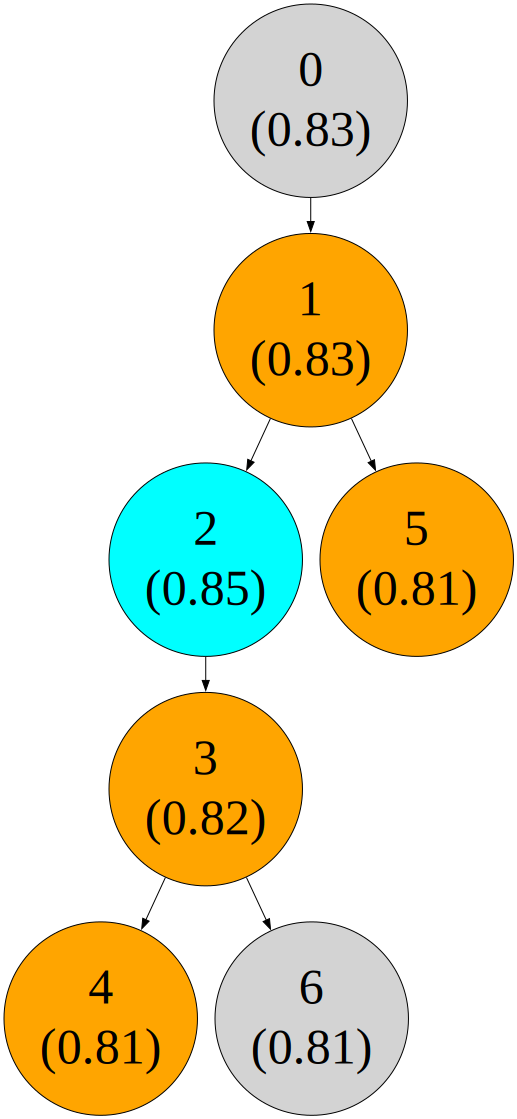

In [23]:
from IPython.display import SVG

SVG('../optimization_results/graphviz_medical_chronology.svg')

In [24]:
optimized_example = base_signature_agent.run_signature_sync(
    MedicalRecordInput(text=TEST_TEXT),
    candidate=result.best_candidate,
)

display(Markdown(str(optimized_example.output)))

2025-04-02

EMT-P Daniel Rivera, License #EMTP-21478

Patient involved in MVC at 17:20 after rear-end collision; reports neck pain (6/10) radiating to shoulders, mid-thoracic pain (5/10), mild nausea, frontal headache (4/10); denies other injuries. Physical exam: cervical tenderness at C4–C6, thoracic tenderness T6–T8, neuro intact, GCS 15. Interventions: cervical collar, long spine board, IV access, fentanyl 50 mcg IV (pain reduced from 6/10 to 4/10). Transported emergently to Starlight Regional Medical Center. Handoff at 18:09.

In [25]:
Markdown(base_output_summary)

2025-04-02

EMT-P Daniel Rivera

Emergency medical response for patient Jonathan Parker involved in rear-end motor vehicle collision. Patient displayed neck and mid-back pain, mild headache, and was transported to Starlight Regional Medical Center with cervical spine immobilization, IV access, pain medication administered, and comprehensive handoff to ED staff.